In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)
human_lombardo

,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf,MW,HBA,HBD,TPSA_NO,RotBondCount,MoKa.LogP,MoKa.LogD7.4,molecular_weight_smiles_r
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,1.015,4.35,0.33,3.70,15.00,477.47,12.0,5.0,207.3,11.0,0.35,-6.00,475.161514
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,12.000,8.90,NaN,22.30,50.70,300.44,2.0,1.0,37.3,6.0,5.40,5.40,299.201654
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,0.530,0.29,0.01,30.38,78.50,532.53,12.0,4.0,169.8,11.0,2.40,-2.60,529.176450
3,C#CC[NH+](C)C(C)Cc1ccccc1,1.900,20.00,0.13,1.60,1.30,187.28,1.0,0.0,3.2,5.0,2.80,2.30,188.143376
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,1.100,1.60,NaN,11.70,10.90,267.24,8.0,4.0,130.8,3.0,-3.20,-3.20,267.085521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,3.600,8.00,NaN,10.50,8.20,220.27,4.0,1.0,33.7,1.0,0.93,-0.46,221.128454
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,6.900,5.10,0.35,23.00,16.00,243.39,1.0,0.0,3.2,2.0,5.30,3.70,244.205976
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,4.100,8.60,0.50,7.80,7.30,262.35,2.0,1.0,24.4,3.0,2.80,-0.64,263.154275
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,3.900,19.67,NaN,3.45,2.29,265.35,3.0,1.0,27.6,5.0,2.80,0.28,266.165174


In [4]:
human_lombardo=  human_lombardo[["smiles_r","human_VDss_L_kg", "human_CL_mL_min_kg"
                               ,"human_fup", "human_mrt", "human_thalf" ]]
human_smiles = human_lombardo[["smiles_r"]]
human_lombardo
for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


/tmp/ipykernel_148974/3302494870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])


,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426
...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835


In [5]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426
...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835


In [6]:
from sklearn.feature_selection import VarianceThreshold
from rdkit.Chem import AllChem
from itertools import compress

In [7]:
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from pandarallel import pandarallel
from rdkit import Chem
from mordred import Calculator, descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))

def GetMACCSkeys(s):
    x = Chem.MolFromSmiles(s)
    return (MACCSkeys.GenMACCSKeys(x))

def addfps(data, fn, nm):
    pandarallel.initialize()
    array=[]
    array = np.stack(data['smiles_r'].parallel_apply(fn))
    collection = []
    for x in np.arange(array.shape[1]):
        x = nm+str(x)
        collection.append(x)
    table = pd.DataFrame(array, columns=collection)
    df= pd.concat([data, table], axis=1)
    return df

In [8]:
human_lombardo=addfps(human_lombardo, MorganFingerprint, 'M')
human_lombardo

INFO: Pandarallel will run on 112 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf,M0,M1,M2,M3,...,M2038,M2039,M2040,M2041,M2042,M2043,M2044,M2045,M2046,M2047
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

#Morgan Fingerprint Correlations
#Active vs Inactive

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

    # proof and make a list of SMILES
def calculate_similarity_test_vs_train(test, train):
    
    df_smiles_a = test['smiles_r']
    df_smiles_i = train['smiles_r']


    c_smiles_a = []
    for ds in df_smiles_a:
        try:
            cs = Chem.CanonSmiles(ds)
            c_smiles_a.append(cs)
        except:
            print("test")
            print('Invalid SMILES:', ds)
    print()


    c_smiles_i = []
    for ds in df_smiles_i:
        try:
            cs = Chem.CanonSmiles(ds)
            c_smiles_i.append(cs)
        except:
            print("train")
            print('Invalid SMILES:', ds)
    print()



    # make a list of mols
    ms_a = [Chem.MolFromSmiles(x) for x in c_smiles_a]

    # make a list of fingerprints (fp)
    fps_a = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in ms_a]

    # make a list of mols
    ms_i = [Chem.MolFromSmiles(x) for x in c_smiles_i]

    # make a list of fingerprints (fp)
    fps_i = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in ms_i]



    # the list for the dataframe
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates

    for a in range(len(fps_a)):

        s = DataStructs.BulkTanimotoSimilarity(fps_a[a], fps_i)    
        for m in range(len(s)):
            qu.append(c_smiles_a[a])
            ta.append(c_smiles_i[m])
            sim.append(s[m])

    # build the dataframe and sort it
    d = {'query':qu, 'target':ta, 'MFP_Tc':sim}
    df_final_ai= pd.DataFrame(data=d)
    #df_final_ai = df_final_ai.sort_values('MFP_Tc', ascending=False)
    #df_final_ai=df_final_ai.reset_index()
    return(df_final_ai)

    # save as csv
    #df_final.to_csv('third.csv', index=False, sep=',')

In [10]:
import numpy as np

def quantile_curves(D):

    quantiles = [0.25, 0.5, 0.75]
    print('quantiles:\n', quantiles)

    moments = [f'moment {i}' for i in range(1)]

    #D = np.array(df_plot[df_plot["Category"]=="Toxic vs Toxic"]["MFP_Tc"])

    quantile_values = np.quantile(D , quantiles , axis=0)
    print('quantile_values (for each moment):\n', quantile_values)

    quantile_curves = np.zeros((len(quantiles)+1))

    quantile_curves[0] = np.mean(np.ma.masked_array(D, mask=D>quantile_values[0]), axis=0)
    for q in range(len(quantiles)-1):
      quantile_curves[q+1] = np.mean(np.ma.masked_array(D, mask=np.logical_or(D<quantile_values[q], D>quantile_values[q+1])), axis=0)
    quantile_curves[len(quantiles)] = np.mean(np.ma.masked_array(D, mask=D<quantile_values[len(quantiles)-1]), axis=0)

    print('mean for each group and at each moment:')
    print(quantile_curves)
    return(quantile_curves)

In [11]:
import pickle
n_neighbours=5
list_of_lists=[]
df_master=pd.DataFrame()

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    for i in range(42,47):
        
        df = human_lombardo

        print(endpoint)    
        df = df.dropna(subset=[endpoint]).reset_index(drop=True)

        #Nested Cross Validation    
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(df)):
            print(split)

            train= df.iloc[train_index]
            test= df.iloc[test_index]
            
            print(len(test))
            
            df_final_ai = calculate_similarity_test_vs_train(test, train)
            df_final_ai = df_final_ai.sort_values('MFP_Tc', ascending=False)
            df_final_ai = df_final_ai.reset_index()
            df_final_ai


            df_final_ai_2 = pd.DataFrame()
            for compound in df_final_ai["query"].unique():

                compounds_wise = pd.DataFrame()
                compounds_wise = df_final_ai[df_final_ai["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:n_neighbours, :]
                df_final_ai_2 = pd.concat([df_final_ai_2, compounds_wise])

          
            df_final_ai_2 = df_final_ai_2.groupby('query').mean().sort_values("MFP_Tc").reset_index()
            df_final_ai_2["endpoint"]=endpoint
            df_final_ai_2["random_state"]=i
            df_final_ai_2["split"]=split
            
            df_master = pd.concat([df_master, df_final_ai_2]).reset_index(drop=True)

human_VDss_L_kg
0
250


1
250


2
250


3
250


4
249


human_VDss_L_kg
0
250


1
250


2
250


3
250


4
249


human_VDss_L_kg
0
250


1
250


2
250


3
250


4
249


human_VDss_L_kg
0
250


1
250


2
250


3
250


4
249


human_VDss_L_kg
0
250


1
250


2
250


3
250


4
249


human_CL_mL_min_kg
0
257


1
256


2
256


3
256


4
256


human_CL_mL_min_kg
0
257


1
256


2
256


3
256


4
256


human_CL_mL_min_kg
0
257


1
256


2
256


3
256


4
256


human_CL_mL_min_kg
0
257


1
256


2
256


3
256


4
256


human_CL_mL_min_kg
0
257


1
256


2
256


3
256


4
256


human_fup
0
176


1
176


2
176


3
176


4
175


human_fup
0
176


1
176


2
176


3
176


4
175


human_fup
0
176


1
176


2
176


3
176


4
175


human_fup
0
176


1
176


2
176


3
176


4
175


human_fup
0
176


1
176


2
176


3
176


4
175


human_mrt
0
249


1
249


2
249


3
248


4
248


human_mrt
0
249


1
249


2
249


3
248


4
248


human_mrt
0
249


1
249


2
249


3
248


4
248


human_mrt
0
249


1
249



In [12]:
df_master

,query,index,MFP_Tc,endpoint,random_state,split
0,FC(F)(F)C(F)(F)C(F)(F)F,195373.0,0.079048,human_VDss_L_kg,42,0
1,[NH3+]C12CC3CC(CC(C3)C1)C2,237385.2,0.140456,human_VDss_L_kg,42,0
2,CC1(C)O[C@@H]2[C@@H](CO[C@@]3(COS(N)(=O)=O)OC(...,35478.4,0.156877,human_VDss_L_kg,42,0
3,NC(=[NH2+])N=c1[nH]c(CSCCC(=[NH2+])NS(N)(=O)=O...,200497.8,0.165661,human_VDss_L_kg,42,0
4,C[C@@](O)(/C=C/[C@H]1CC=CC(=O)O1)[C@@H](C[C@@H...,145478.6,0.166903,human_VDss_L_kg,42,0
...,...,...,...,...,...,...
29580,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(CSc3nc...,101634.4,0.692836,human_thalf,46,4
29581,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(C)CS[C...,100622.8,0.714392,human_thalf,46,4
29582,CC(=O)[C@]1(O)Cc2c([O-])c3c(c([O-])c2[C@@H](O[...,17642.6,0.736391,human_thalf,46,4
29583,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,128029.8,0.746316,human_thalf,46,4


In [13]:
df_master["key"] =  df_master["endpoint"].astype(str) + df_master["query"].astype(str) + df_master["random_state"].astype(str)+ df_master["split"].astype(str)
df_master

,query,index,MFP_Tc,endpoint,random_state,split,key
0,FC(F)(F)C(F)(F)C(F)(F)F,195373.0,0.079048,human_VDss_L_kg,42,0,human_VDss_L_kgFC(F)(F)C(F)(F)C(F)(F)F420
1,[NH3+]C12CC3CC(CC(C3)C1)C2,237385.2,0.140456,human_VDss_L_kg,42,0,human_VDss_L_kg[NH3+]C12CC3CC(CC(C3)C1)C2420
2,CC1(C)O[C@@H]2[C@@H](CO[C@@]3(COS(N)(=O)=O)OC(...,35478.4,0.156877,human_VDss_L_kg,42,0,human_VDss_L_kgCC1(C)O[C@@H]2[C@@H](CO[C@@]3(C...
3,NC(=[NH2+])N=c1[nH]c(CSCCC(=[NH2+])NS(N)(=O)=O...,200497.8,0.165661,human_VDss_L_kg,42,0,human_VDss_L_kgNC(=[NH2+])N=c1[nH]c(CSCCC(=[NH...
4,C[C@@](O)(/C=C/[C@H]1CC=CC(=O)O1)[C@@H](C[C@@H...,145478.6,0.166903,human_VDss_L_kg,42,0,human_VDss_L_kgC[C@@](O)(/C=C/[C@H]1CC=CC(=O)O...
...,...,...,...,...,...,...,...
29580,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(CSc3nc...,101634.4,0.692836,human_thalf,46,4,human_thalfCON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-...
29581,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(C)CS[C...,100622.8,0.714392,human_thalf,46,4,human_thalfCON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-...
29582,CC(=O)[C@]1(O)Cc2c([O-])c3c(c([O-])c2[C@@H](O[...,17642.6,0.736391,human_thalf,46,4,human_thalfCC(=O)[C@]1(O)Cc2c([O-])c3c(c([O-])...
29583,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,128029.8,0.746316,human_thalf,46,4,human_thalfCOc1cccc2c1C(=O)c1c([O-])c3c(c([O-]...


In [14]:
df_master.to_csv("Cross_val_compounds_similarity_to_train_5nn.csv", index=False)

<AxesSubplot:>

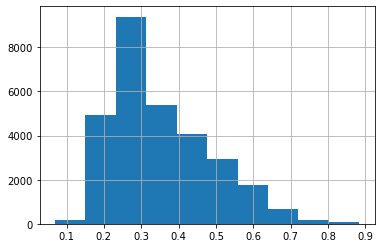

In [15]:
df_master.MFP_Tc.hist()

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_master = pd.read_csv("Cross_val_compounds_similarity_to_train_5nn.csv")
df_master

,query,index,MFP_Tc,endpoint,random_state,split,key
0,FC(F)(F)C(F)(F)C(F)(F)F,195373.0,0.079048,human_VDss_L_kg,42,0,human_VDss_L_kgFC(F)(F)C(F)(F)C(F)(F)F420
1,[NH3+]C12CC3CC(CC(C3)C1)C2,237385.2,0.140456,human_VDss_L_kg,42,0,human_VDss_L_kg[NH3+]C12CC3CC(CC(C3)C1)C2420
2,CC1(C)O[C@@H]2[C@@H](CO[C@@]3(COS(N)(=O)=O)OC(...,35478.4,0.156877,human_VDss_L_kg,42,0,human_VDss_L_kgCC1(C)O[C@@H]2[C@@H](CO[C@@]3(C...
3,NC(=[NH2+])N=c1[nH]c(CSCCC(=[NH2+])NS(N)(=O)=O...,200497.8,0.165661,human_VDss_L_kg,42,0,human_VDss_L_kgNC(=[NH2+])N=c1[nH]c(CSCCC(=[NH...
4,C[C@@](O)(/C=C/[C@H]1CC=CC(=O)O1)[C@@H](C[C@@H...,145478.6,0.166903,human_VDss_L_kg,42,0,human_VDss_L_kgC[C@@](O)(/C=C/[C@H]1CC=CC(=O)O...
...,...,...,...,...,...,...,...
29580,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(CSc3nc...,101634.4,0.692836,human_thalf,46,4,human_thalfCON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-...
29581,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(C)CS[C...,100622.8,0.714392,human_thalf,46,4,human_thalfCON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-...
29582,CC(=O)[C@]1(O)Cc2c([O-])c3c(c([O-])c2[C@@H](O[...,17642.6,0.736391,human_thalf,46,4,human_thalfCC(=O)[C@]1(O)Cc2c([O-])c3c(c([O-])...
29583,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,128029.8,0.746316,human_thalf,46,4,human_thalfCOc1cccc2c1C(=O)c1c([O-])c3c(c([O-]...


6245
human_VDss_L_kg


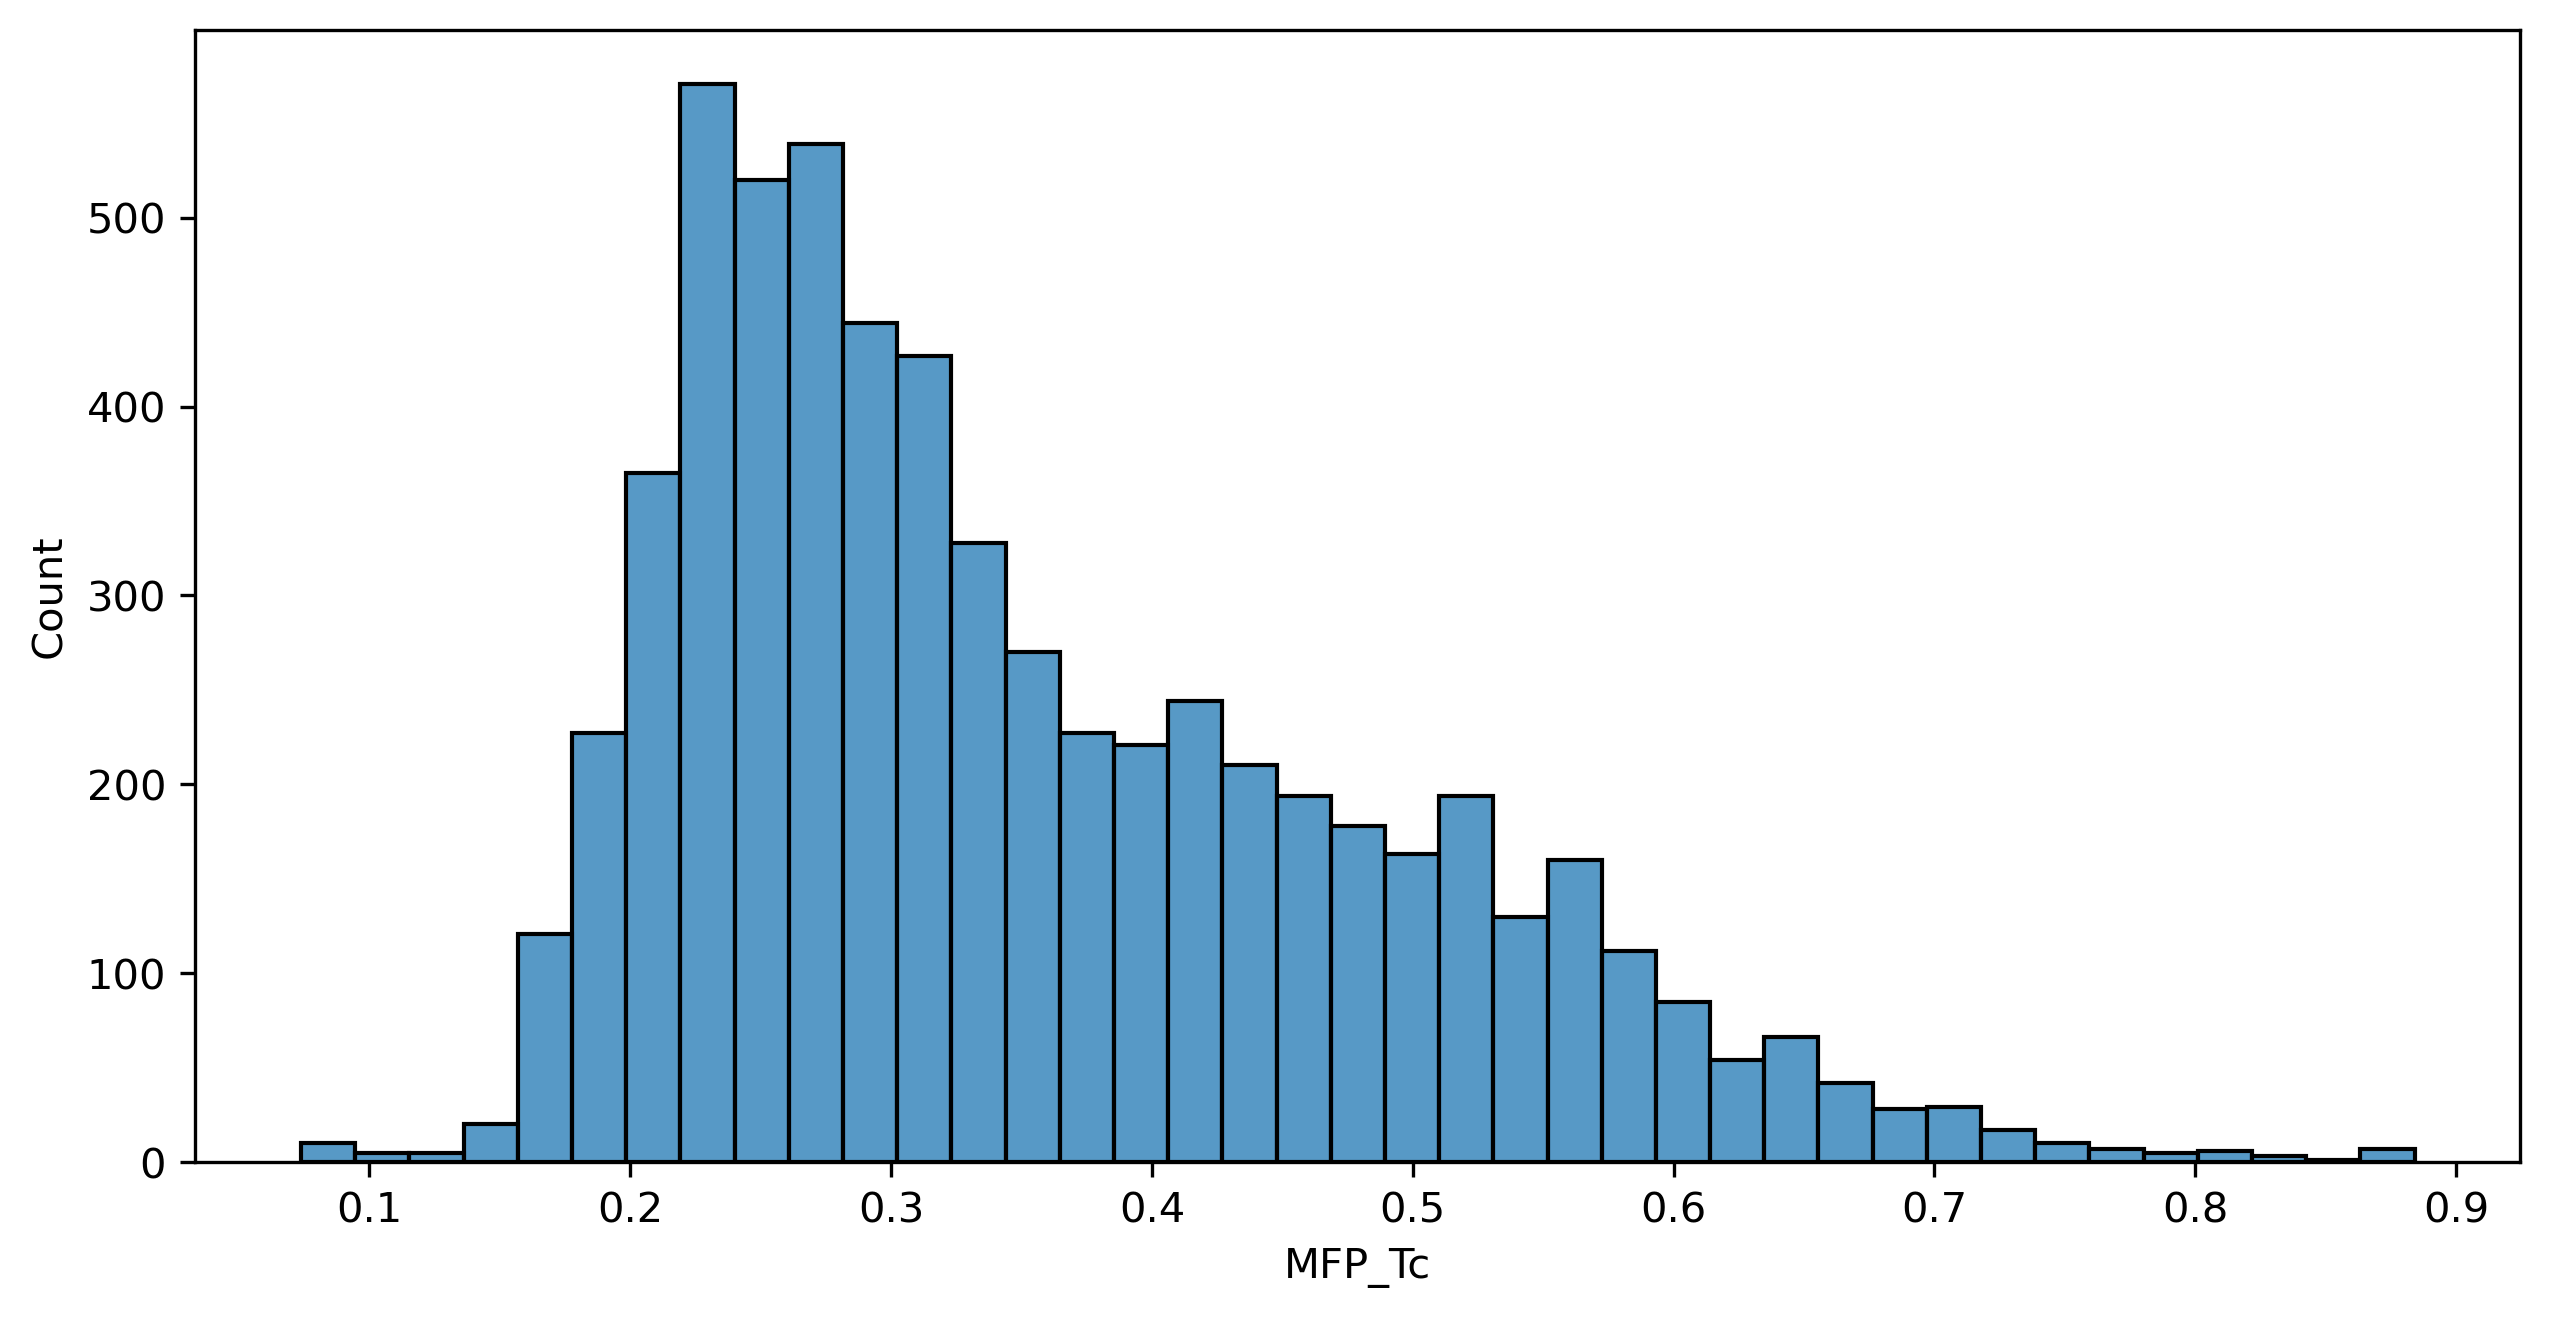

6405
human_CL_mL_min_kg


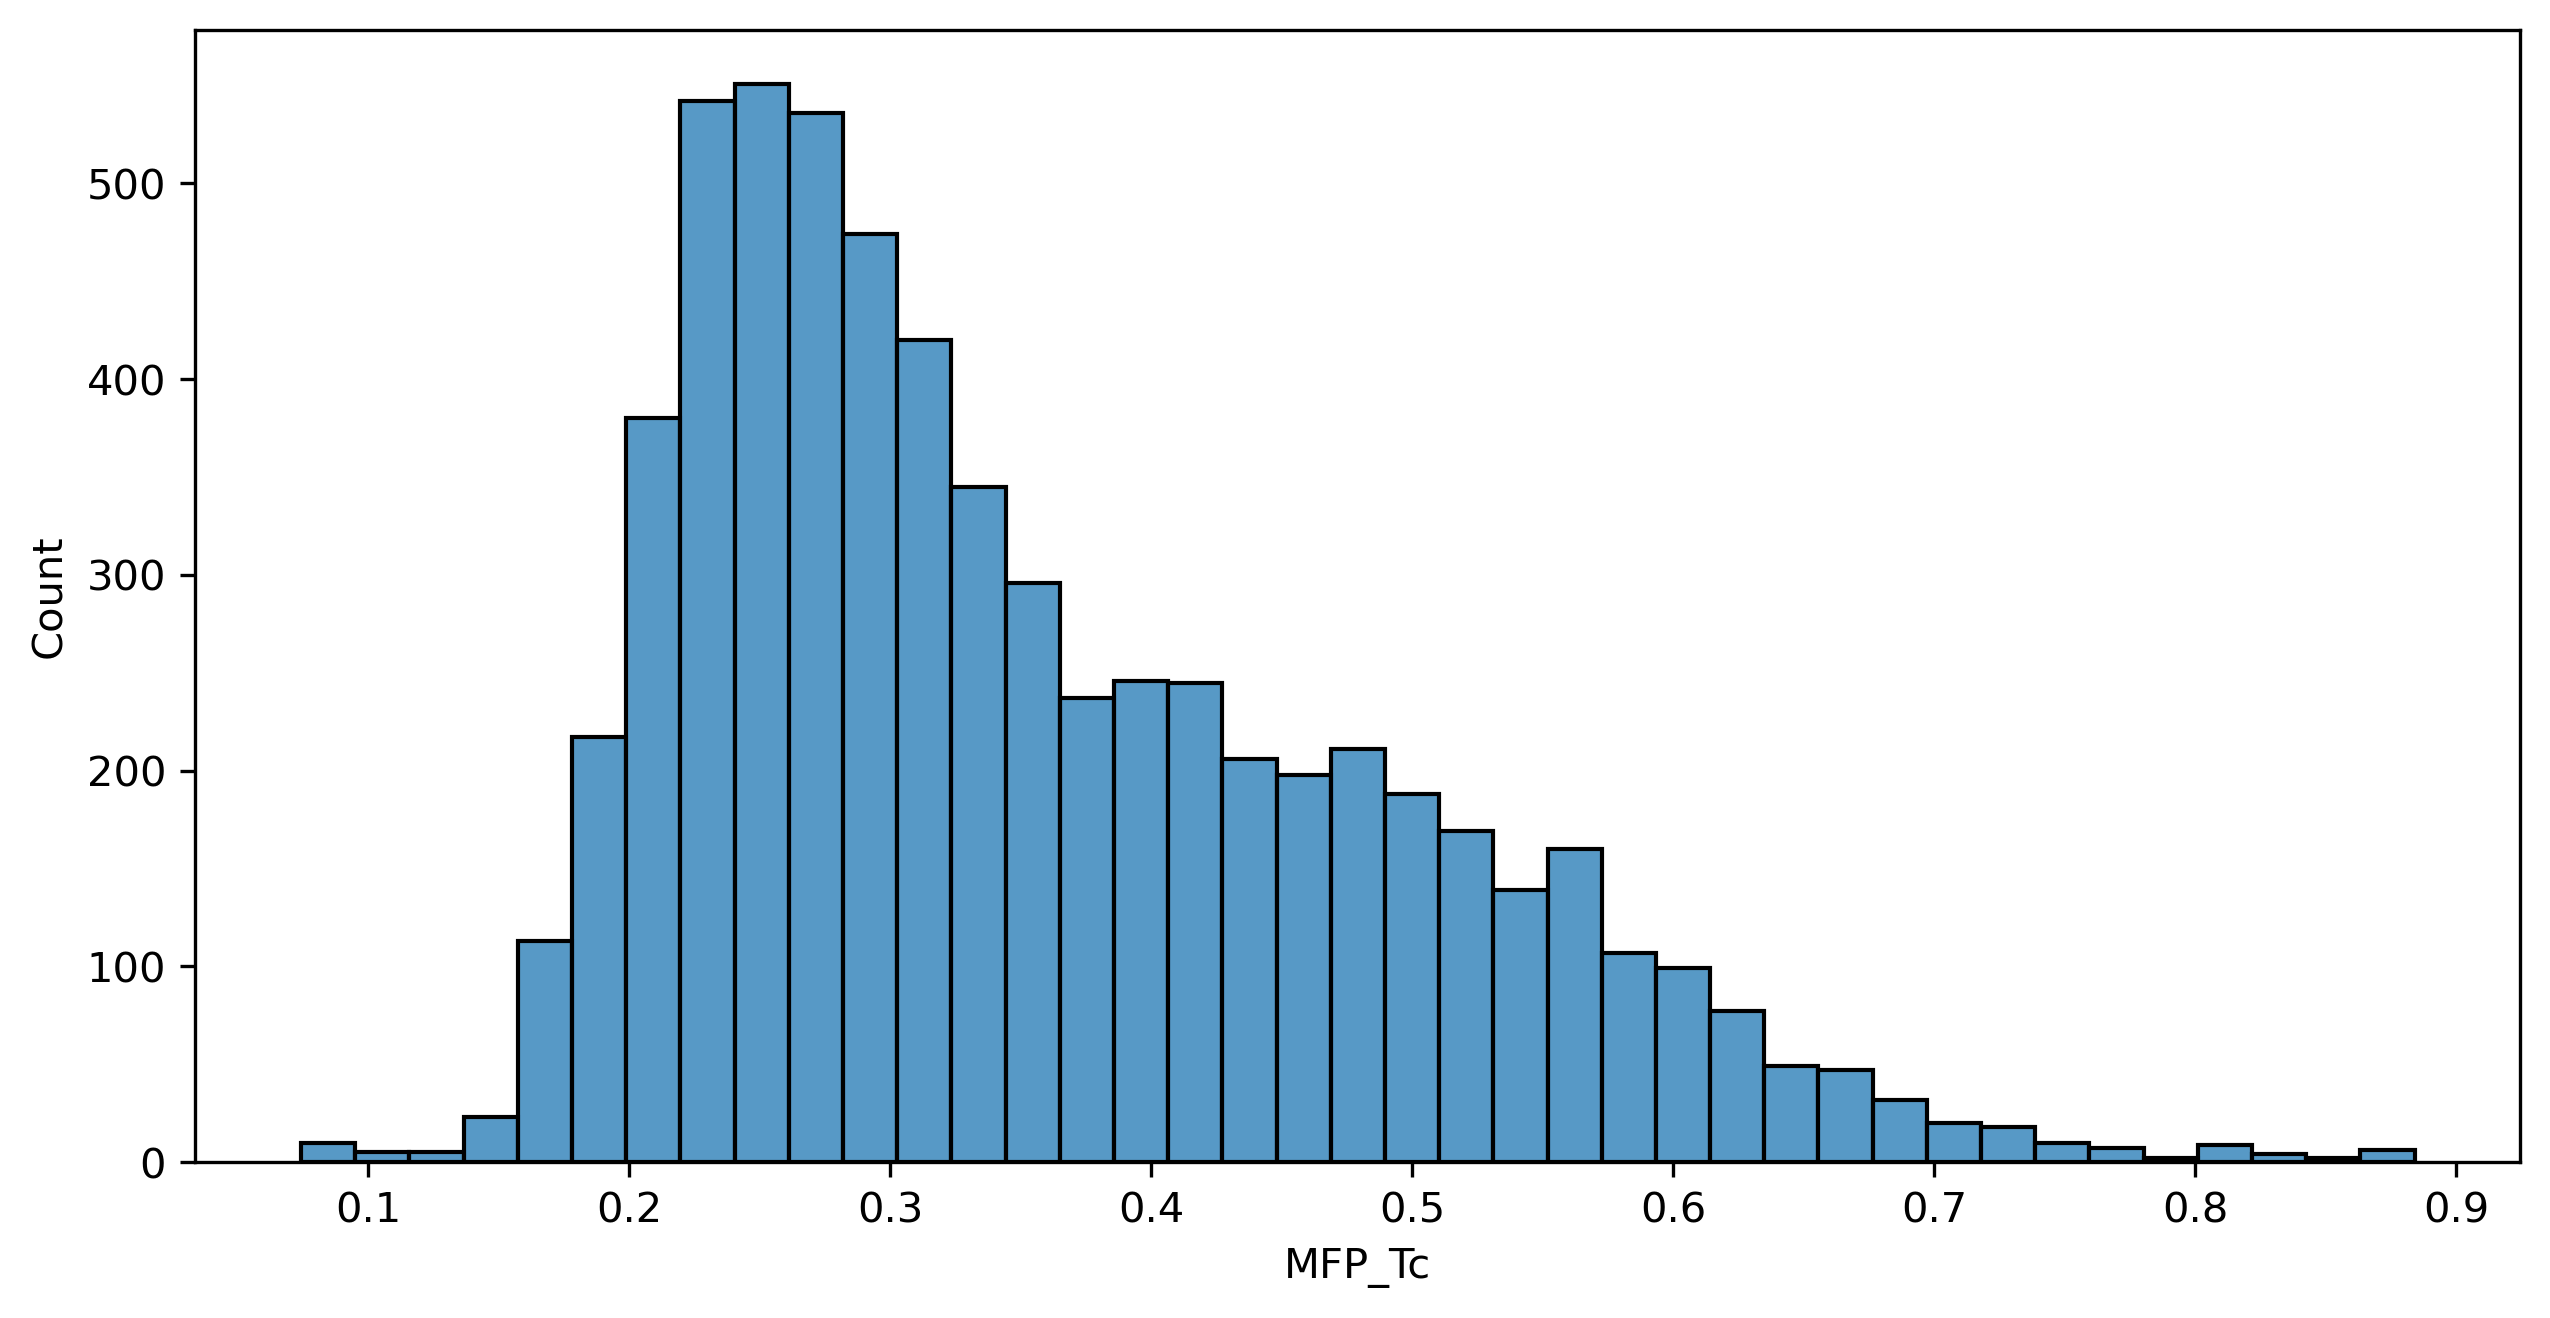

4395
human_fup


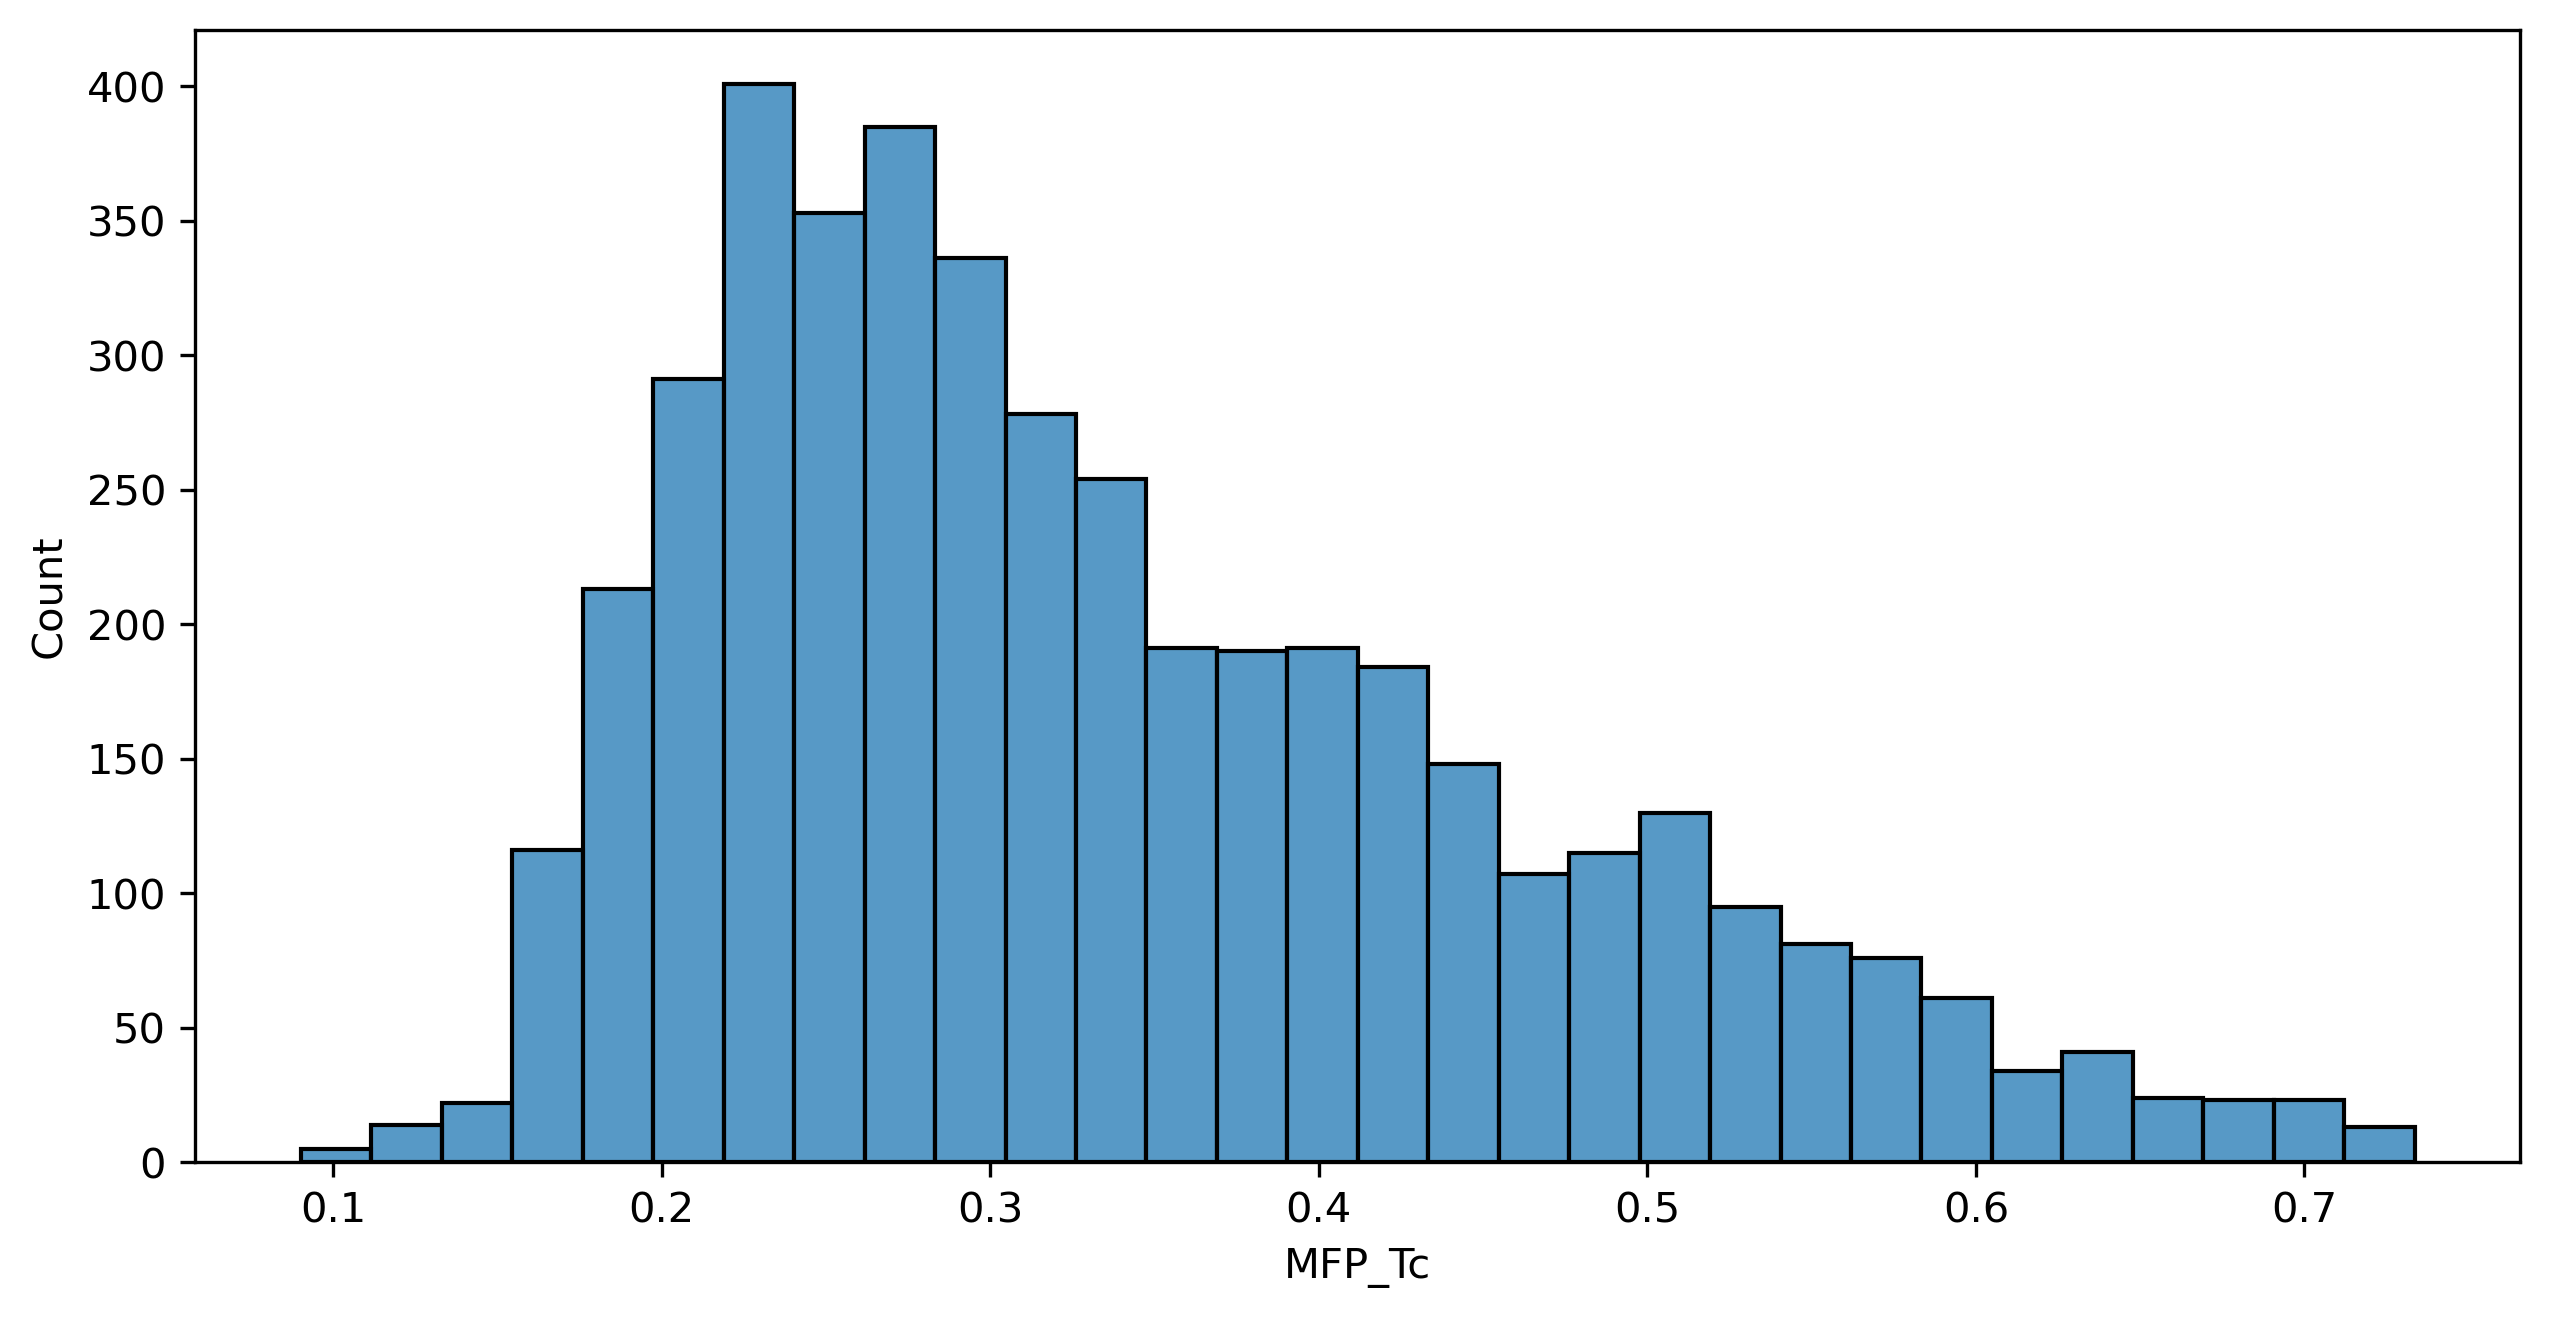

6215
human_mrt


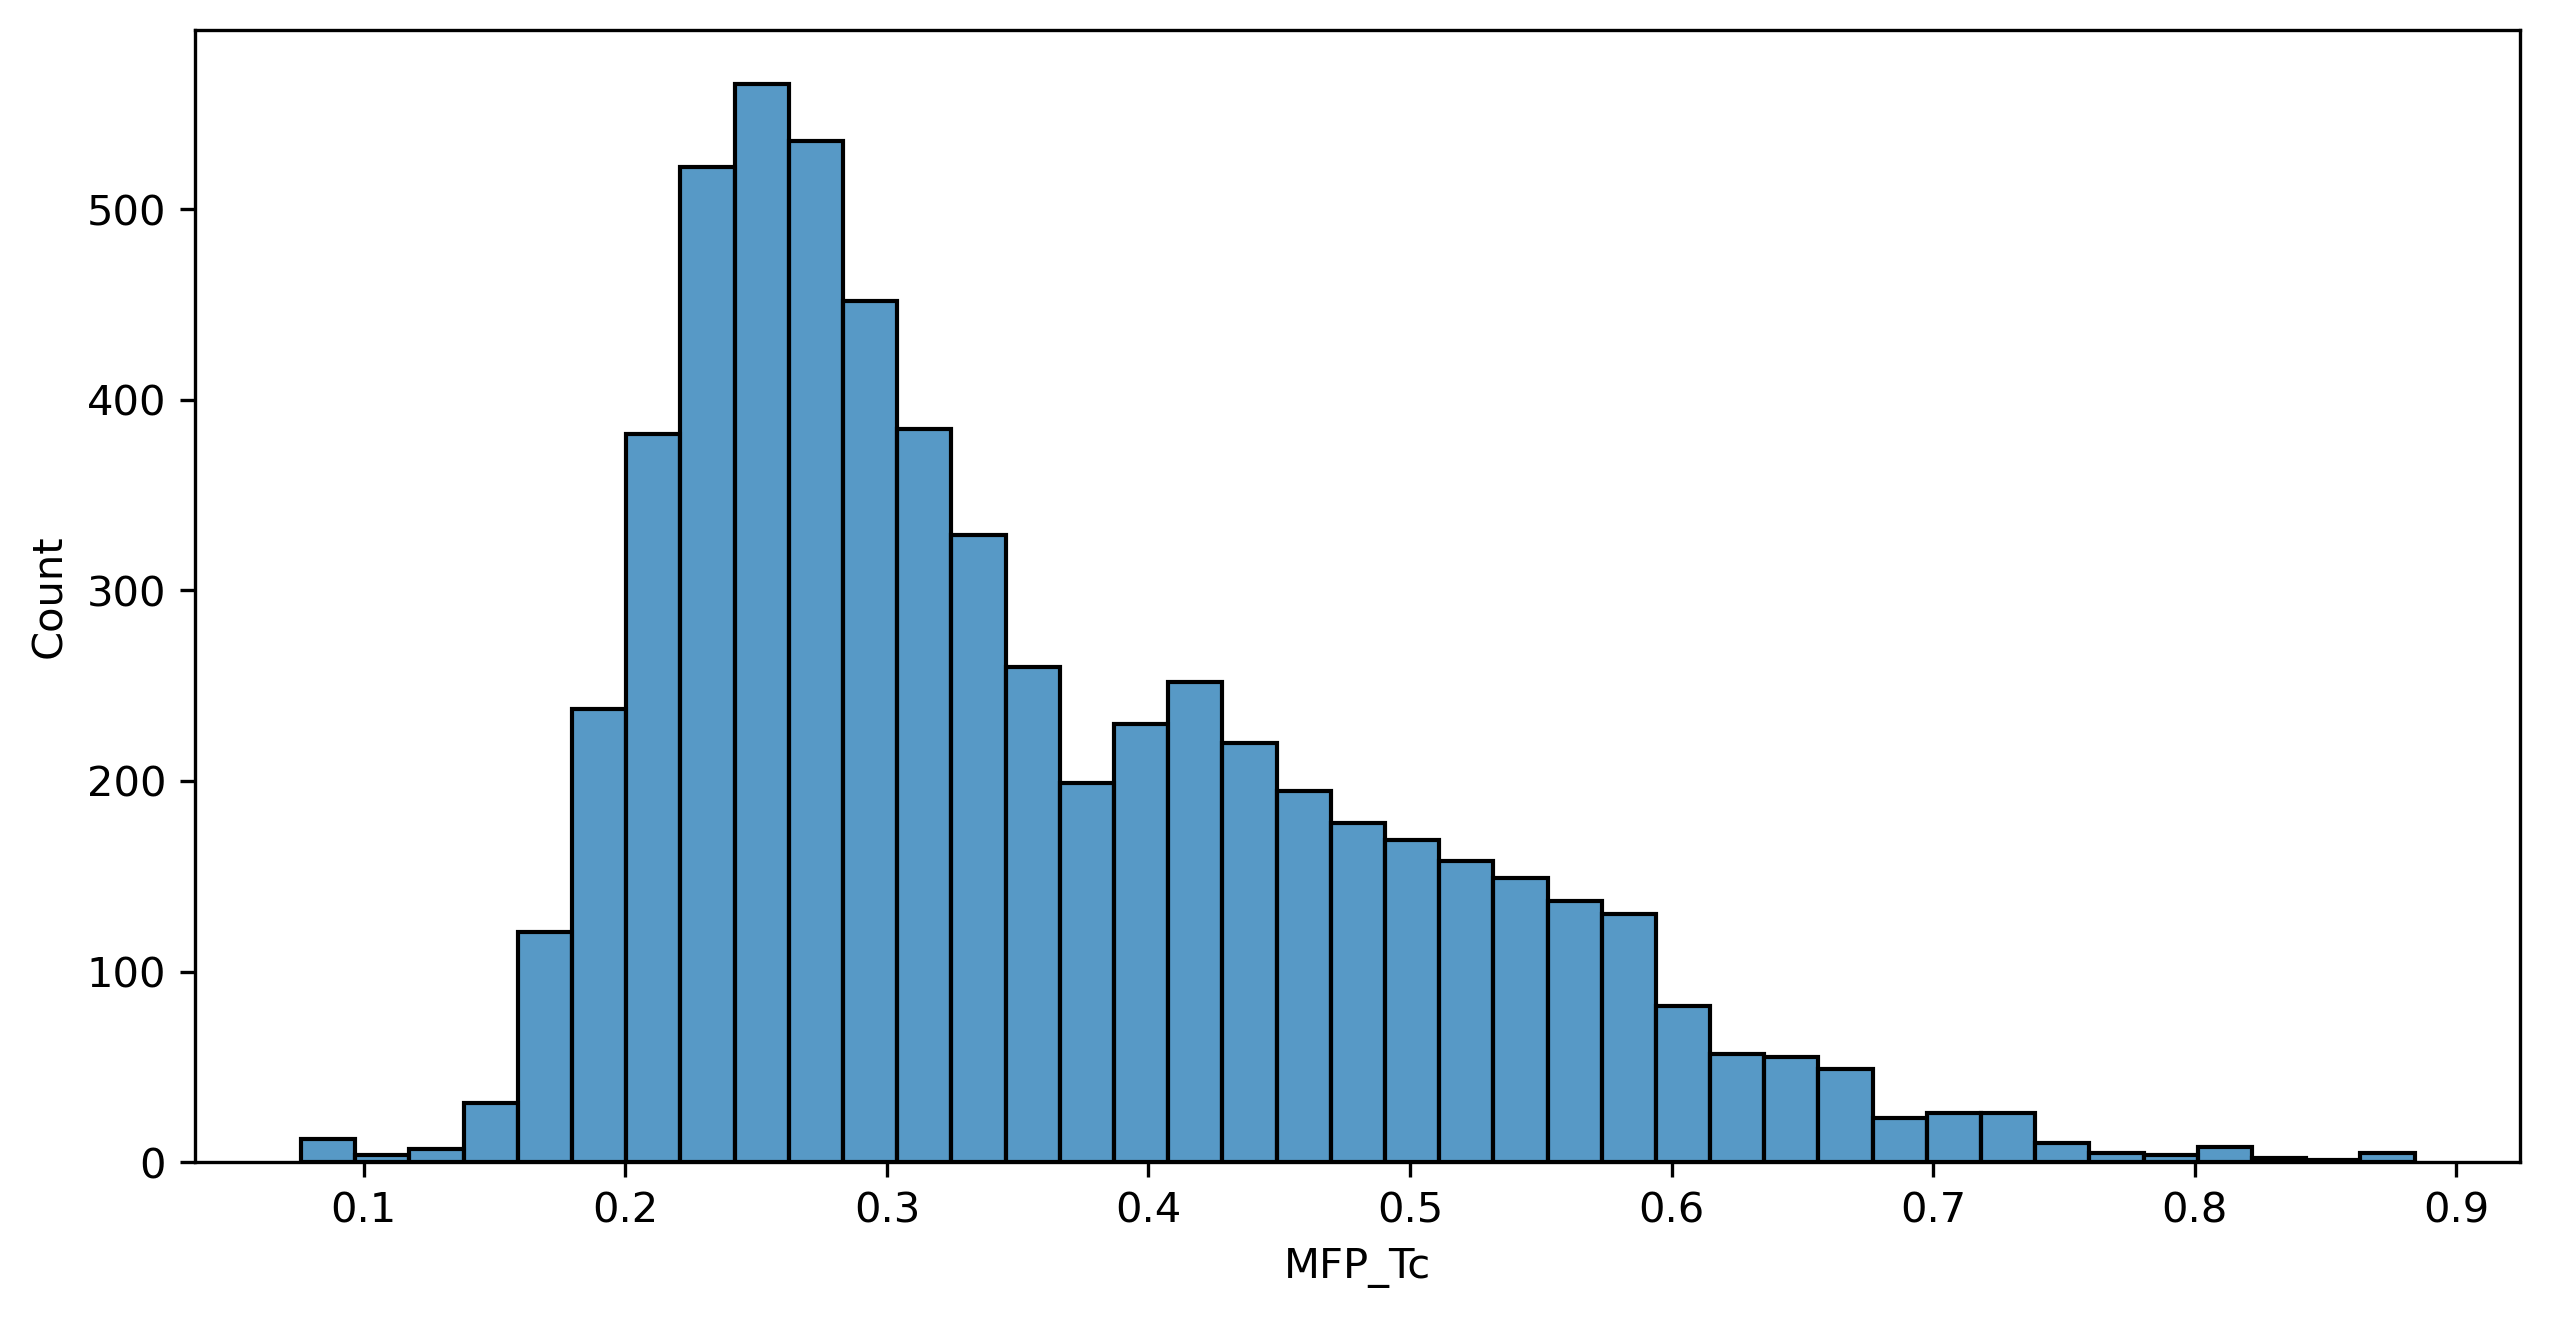

6325
human_thalf


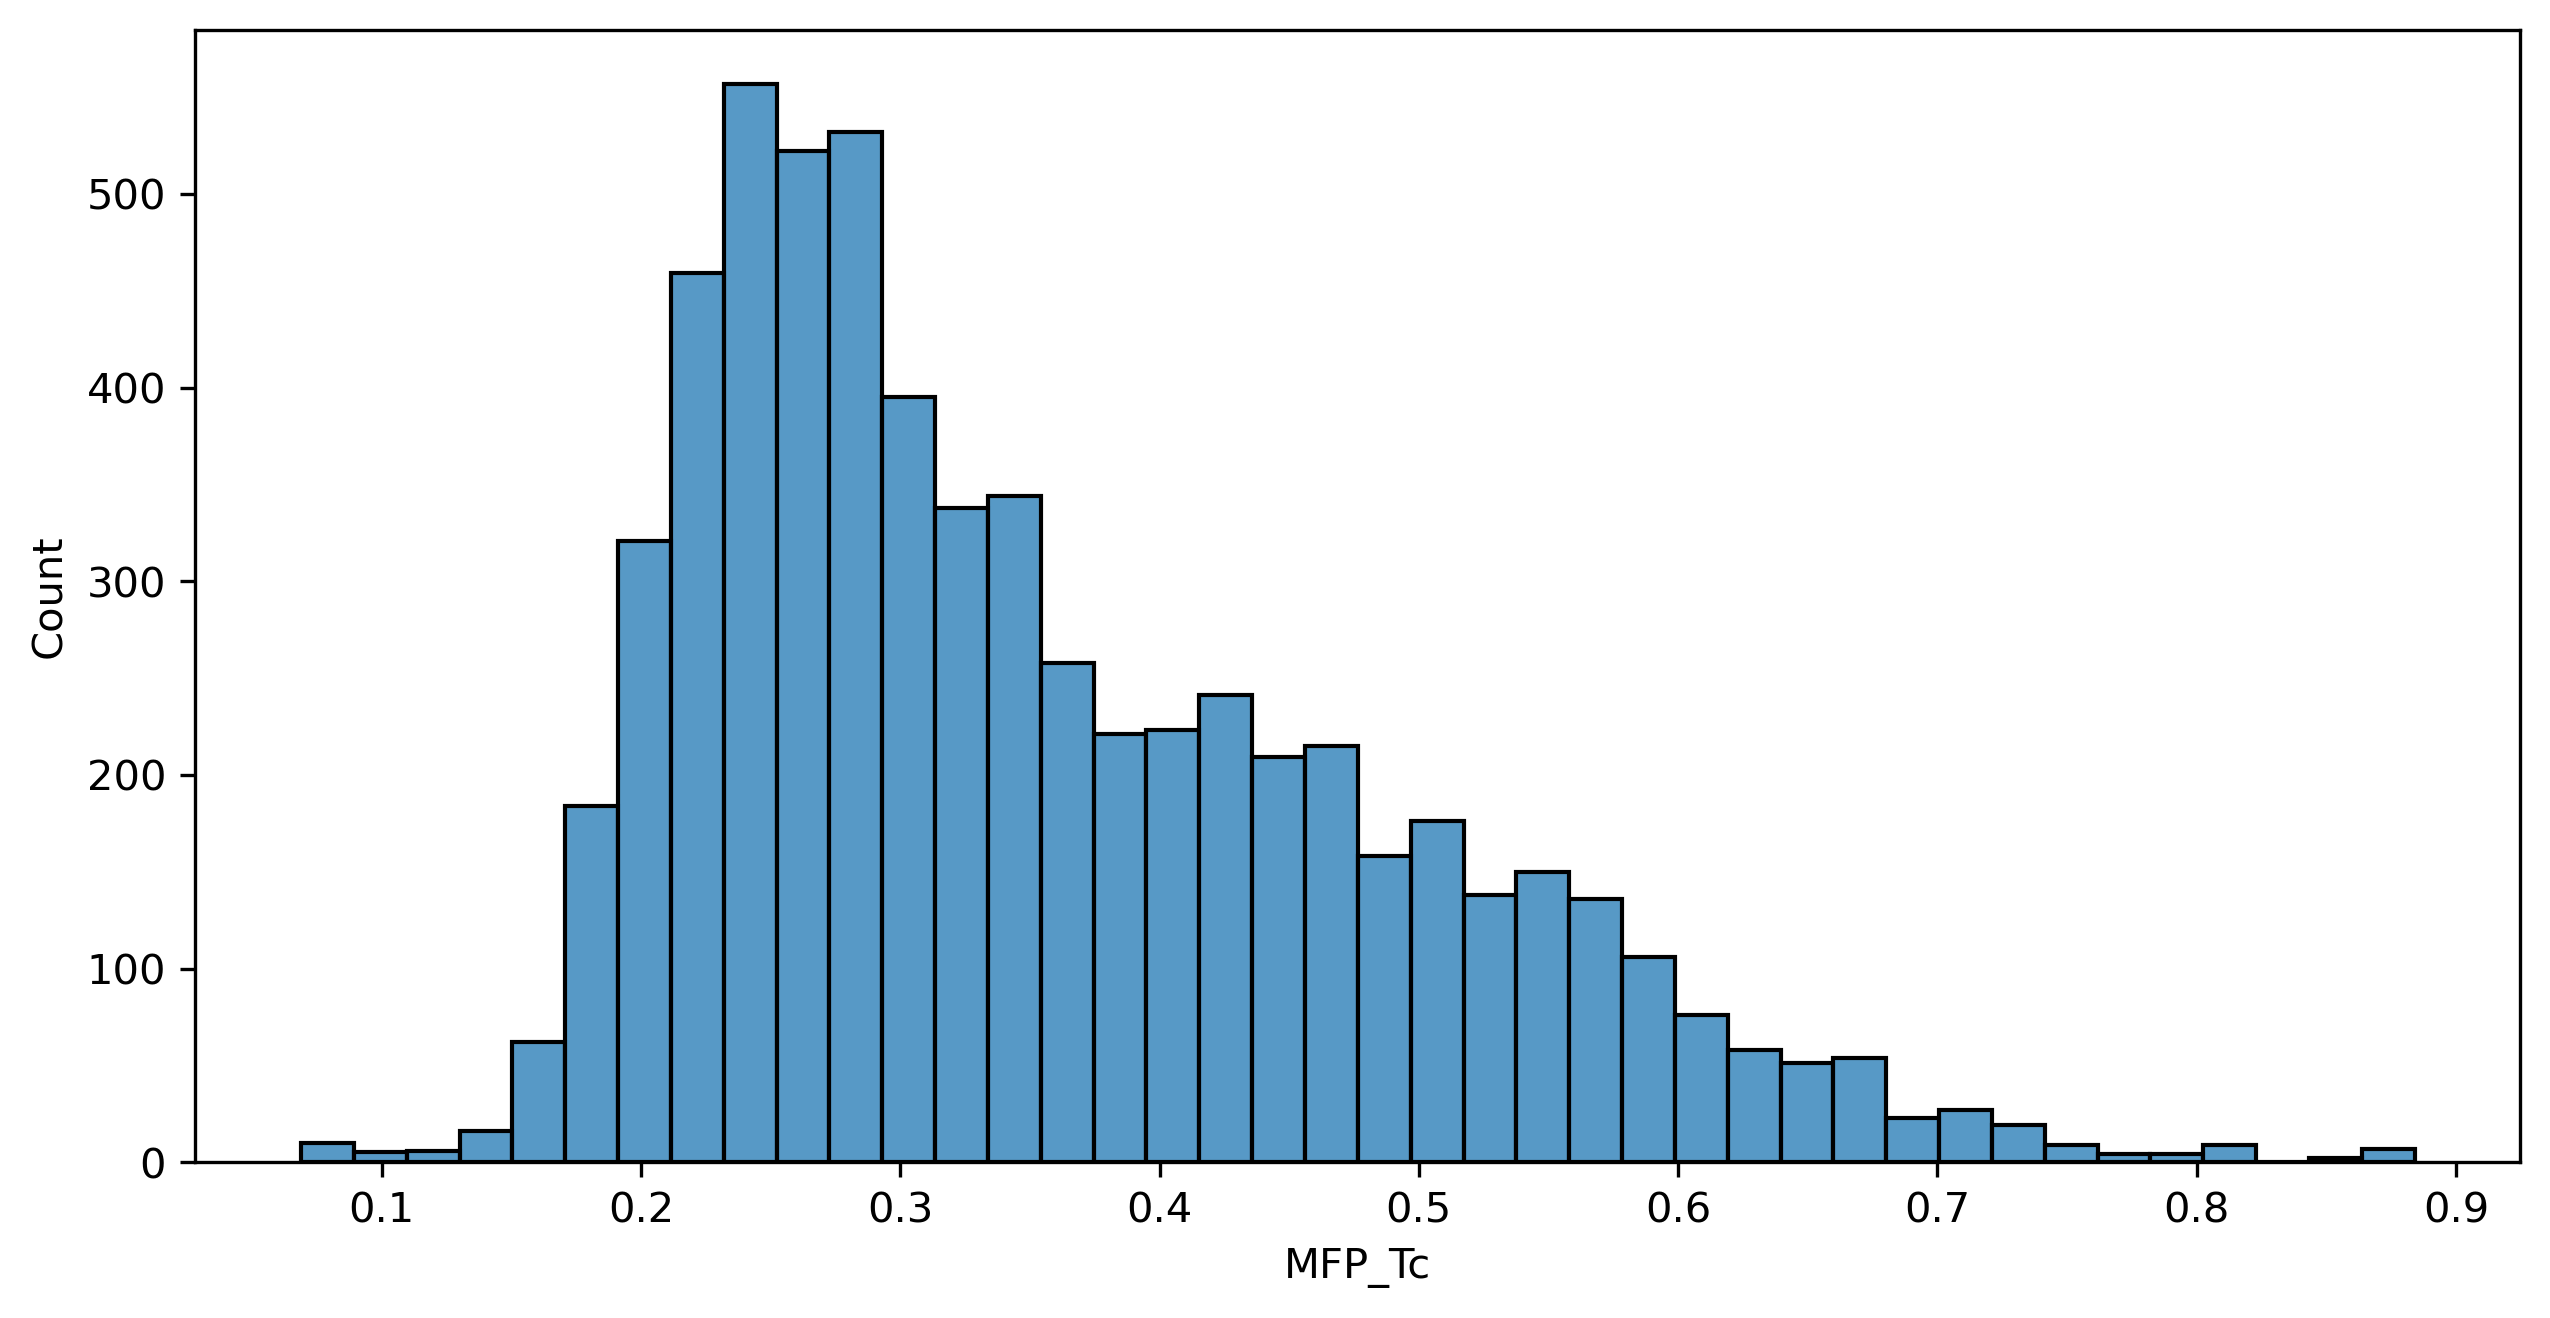

In [17]:
for column in ['human_VDss_L_kg', 'human_CL_mL_min_kg', 'human_fup',
       'human_mrt', 'human_thalf']:
    
    temp=df_master[df_master["endpoint"]==column]
    print(len(temp))
    print(column)
    plt.figure(figsize=(10,5), dpi= 300)
    sns.histplot(data=temp, x="MFP_Tc")
    plt.show()